<a href="https://colab.research.google.com/github/crislpzalc/Pneumonia_detection_CNN/blob/main/Pneumonia_Detection_with_CNN_Google_Colab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pneumonia Detection with CNN - Google Colab Demo
This notebook demonstrates how to use a pre-trained Convolutional Neural Network (CNN) to detect pneumonia from chest X-ray images.

The model was trained using the Chest X-ray dataset (Pneumonia vs Normal), achieving an accuracy of 96.8% on the test set.

GitHub repository: [Pneumonia Detection CNN](https://github.com/crislpzalc/Pneumonia_detection_CNN)

##1. Install Dependencies and Download Pre-trained Model

In [ ]:
import os, matplotlib.pyplot as plt, numpy as np, torch, torchvision.transforms as T, torch.nn as nn, torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from google.colab import files

!pip install -q torch torchvision matplotlib scikit-learn gdown pillow grad-cam
!gdown --id 1KEMtw_Ep-jBlRUxMYzP0enJokceEEFcC -O best_model.pt

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1KEMtw_Ep-jBlRUxMYzP0enJokceEEFcC
From (redirected): https://drive.google.com/uc?id=1KEMtw_Ep-jBlRUxMYzP0enJokceEEFcC&confirm=t&uuid=64d4b3f9-4da0-471f-86e6-e156e850408c
To: /content/best_model.pt
100% 45.0M/45.0M [00:00<00:00, 58.5MB/s]


##2. Define the CNN Architecture
Even if we won't train it again, we need to define the architecture so we can load the weights.

In [ ]:
class Net(nn.Module):
    """Simple CNN with Batch Normalization and Dropout regularisation."""

    def __init__(self) -> None:
        super().__init__()
        # Convolutional block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Convolutional block 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Fully - connected head
        self.fc1 = nn.Linear(32 * 56 * 56, 112)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(112, 84)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(84, 2)

    def forward(self, x) -> torch.Tensor:  # N,C,H,W
        """Forward pass returning raw logits (no softmax)."""
        c1 = self.pool(F.relu(self.bn1(self.conv1(x))))  # N,16,112,112
        c2 = self.pool(F.relu(self.bn2(self.conv2(c1))))  # N,32,56,56
        c2 = torch.flatten(c2, 1)  # N,32*56*56
        f3 = self.dropout1(F.relu(self.fc1(c2)))  # N,112
        f4 = self.dropout2(F.relu(self.fc2(f3)))  # N,84
        out = self.fc3(f4)  # N,2
        return out

##3. Load the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=112, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=112, out_features=84, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

##4. Download 10 public images

In [ ]:
# Drive file-IDs and filenames
image_info = [
    ("1CGqTQCOl7B7gTVz-nM2libX3lF_kQE9H", "normal1.jpeg"),
    ("1Jtn2vwk8rdV3DH2OXurl6XDbaMiLahEE", "normal2.jpeg"),
    ("1l1exQuFifqPCuZvMLllDItXUjQxdJciR", "normal3.jpeg"),
    ("11I1hhDB-OsOPm_lVsmHbnFmxsf3wyvub", "normal4.jpeg"),
    ("1yEueP4Rs43xqFCoUMHJOrvkNoNa8HvqZ", "normal5.jpeg"),
    ("1NGd5yoEShgqeK1ExrYemVIyfAkwcgyLA",   "pneu1.jpeg"),
    ("1-q8HCKanxXah55g-cXoSQ7AZzeVJGcV7",   "pneu2.jpeg"),
    ("1W6G14GDwyCBbMrzCseGrfDn1-91SRUqh",   "pneu3.jpeg"),
    ("1yUdq4iL0tpY_RzYH6EpnBwupbhEs80Nn",   "pneu4.jpeg"),
    ("136WGK2M8DNN6A1RX_8BObCwBZpG_doDa",   "pneu5.jpeg"),
]

for fid, fname in image_info:
    !gdown --id $fid -O $fname

# Load images as PIL list
pil_images = [Image.open(fname).convert("RGB") for _,fname in image_info]

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CGqTQCOl7B7gTVz-nM2libX3lF_kQE9H
To: /content/normal1.jpeg
100% 22.0k/22.0k [00:00<00:00, 33.2MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Jtn2vwk8rdV3DH2OXurl6XDbaMiLahEE
To: /content/normal2.jpeg
100% 21.5k/21.5k [00:00<00:00, 37.6MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://dr

##5. Display gallery

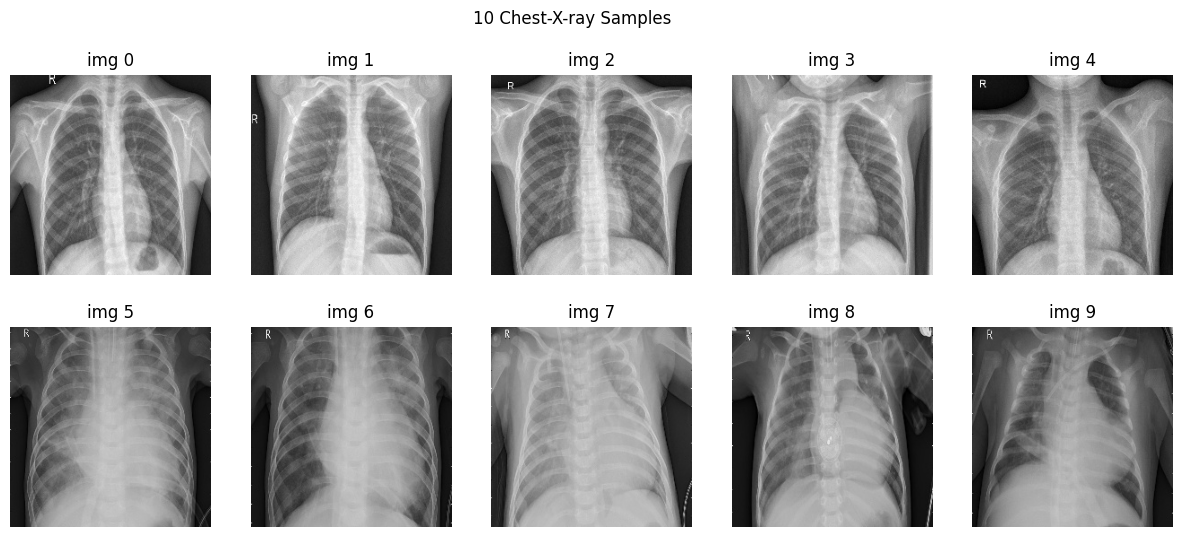

In [ ]:
plt.figure(figsize=(15,6))
for i,img in enumerate(pil_images):
    plt.subplot(2,5,i+1)
    plt.imshow(img); plt.axis('off'); plt.title(f"img {i}")
plt.suptitle("10 Chest-X-ray Samples"); plt.show()

##6. Batch prediction

In [ ]:
transform = T.Compose([T.Resize((224,224)),
                       T.ToTensor(),
                       T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])

tensor_batch = torch.stack([transform(img) for img in pil_images]).to(device)
with torch.no_grad():
    logits = model(tensor_batch)
    probs  = torch.softmax(logits, dim=1).cpu().numpy()

# ground-truth list (0=NORMAL,1=PNEUMONIA)
TRUE_LABELS = [0,0,0,0,0,1,1,1,1,1]
class_names = ['NORMAL','PNEUMONIA']

##7. Confusion Matrix & ROC (thr = 0.5)

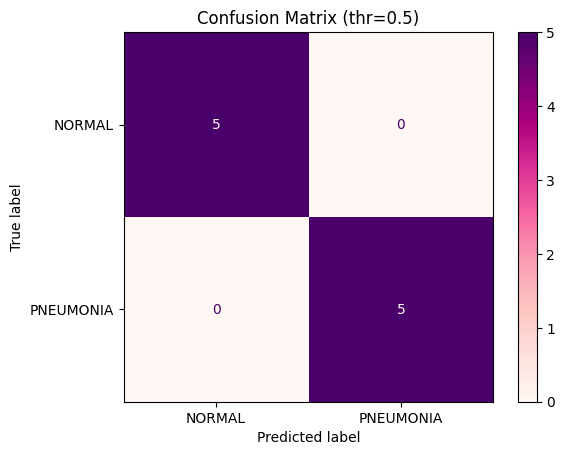

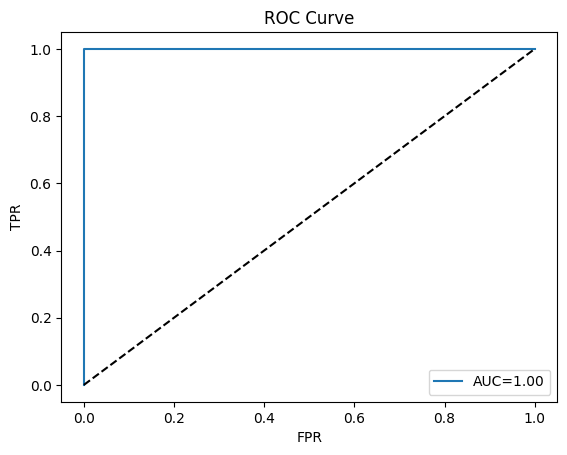

In [ ]:
preds_05 = (probs[:,1] > 0.5).astype(int)

cm = confusion_matrix(TRUE_LABELS, preds_05)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='RdPu')
plt.title("Confusion Matrix (thr=0.5)"); plt.show()

fpr,tpr,_ = roc_curve(TRUE_LABELS, probs[:,1]); AUC = auc(fpr,tpr)
plt.plot(fpr,tpr,label=f"AUC={AUC:.2f}"); plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

##8. Threshold comparison

In [ ]:
for thr in [0.3, 0.5, 0.7]:
    preds = (probs[:,1] > thr).astype(int)
    cm_thr = confusion_matrix(TRUE_LABELS, preds)
    FN, FP = cm_thr[1,0], cm_thr[0,1]
    print(f"Threshold {thr}: False Negatives={FN} | False Positives={FP}")

Threshold 0.3: False Negatives=0 | False Positives=0
Threshold 0.5: False Negatives=0 | False Positives=0
Threshold 0.7: False Negatives=0 | False Positives=0


> ⚠️ **Important Note**
>
> This demo uses only **10 example images**, so metrics like the confusion matrix and ROC curve are **not statistically meaningful**.  
> Since all predictions are correct, changing the classification threshold does not lead to visible differences.
>
> **Want to evaluate the model on the full dataset?**  
> The complete training and evaluation code is available on GitHub:
>
> 🔗 [Pneumonia Detection CNN – GitHub Repository](https://github.com/crislpzalc/Pneumonia_detection_CNN)
>
> ---
>
> **The real value of this notebook:**  
> Upload your own chest X-ray image and get an instant prediction powered by deep learning.  
> Whether you're curious, learning, or testing the model, this tool is built to give you fast and interpretable results.


##9. Upload and Visualize an Image
Upload your own image and classify it.

Saving chest-xray.jpg to chest-xray (1).jpg


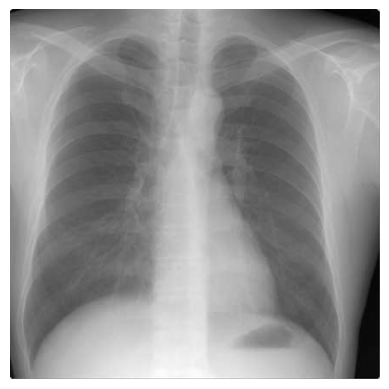

Pneumonia probability = 0.996
Prediction: PNEUMONIA


In [ ]:
uploaded = files.upload()
if uploaded:
    up_name = next(iter(uploaded))
    img_up  = Image.open(up_name).convert("RGB")
    plt.imshow(img_up); plt.axis('off'); plt.show()

    tensor = transform(img_up).unsqueeze(0).to(device)
    with torch.no_grad():
        p = torch.softmax(model(tensor), dim=1)[0,1].item()
    print(f"Pneumonia probability = {p:.3f}")
    print("Prediction:", "PNEUMONIA" if p>0.5 else "NORMAL")

##10. Grad-CAM Visualization

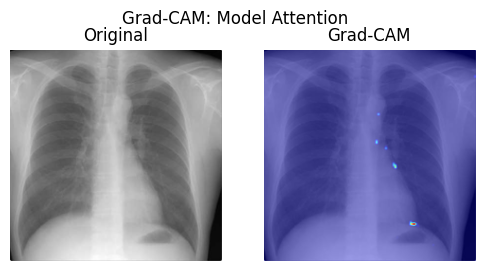

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.conv2

input_tensor = transform(img_up).unsqueeze(0).to(device)

cam = GradCAM(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=input_tensor)[0]
img_np = np.array(img_up.resize((224,224)), dtype=np.float32)/255.0
heatmap = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img_np); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(heatmap); plt.title("Grad-CAM"); plt.axis('off')
plt.suptitle("Grad-CAM: Model Attention")
plt.show()
